In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

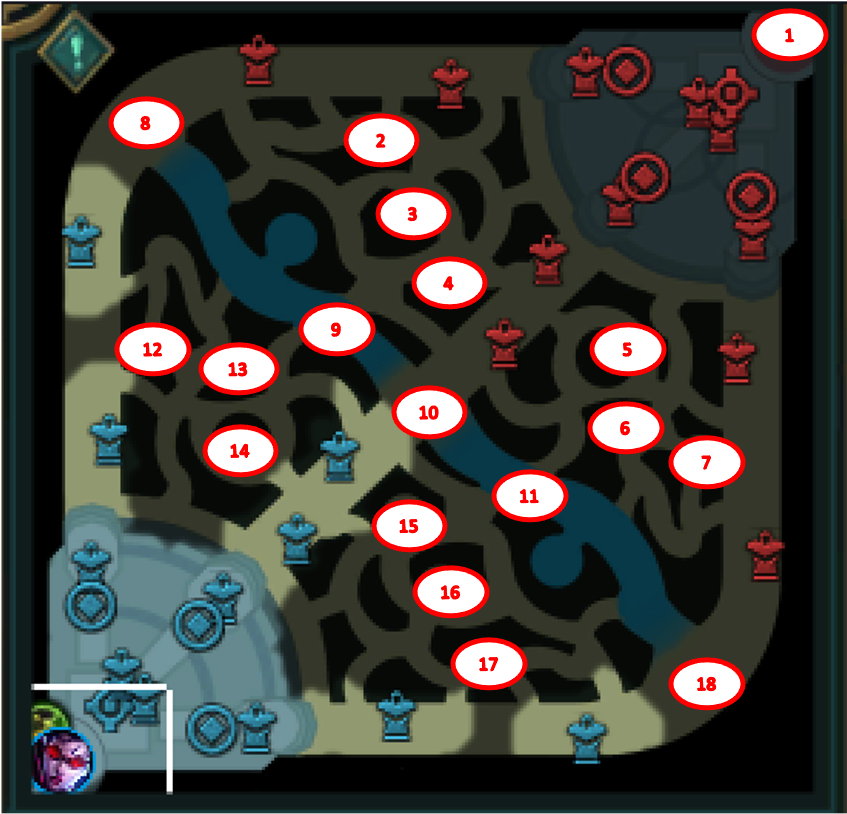

 - 1분 30초 ~ 3분 30초에 정글러가 특정 목적(갱, 정글링, 카운터 등)을 위해 이동하는 동선을 상기로 한정
 - 한정된 동선에 대하여 각각 번호별로 바운딩 박스 범위를 한정하고, 해당 범위 안에 리신의 중심 좌표가 들어간다면, 해당 정수를 맵핑하여 행동에 의미를 부여할 예정

# 동선 위치 정의

In [3]:
idx2loc = {1: '우물',
            2: '돌골렘(상)',
            3: '레드(상)',
            4: '칼날부리(상)',
            5: '늑대(상)',
            6: '블루(상)',
            7: '두꺼비(상)',
            8: '탑',
            9: '바위게(상)',
            10: '미드',
            11: '바위게(하)',
            12: '두꺼비(하)',
            13: '블루(하)',
            14: '늑대(하)',
            15: '칼날부리(하)',
            16: '레드(하)',
            17: '돌골렘(하)',
            18: '봇'}

from collections import OrderedDict

loc2idx = OrderedDict()

for idx, loc in idx2loc.items():
    loc2idx[loc] = idx

In [4]:
print(idx2loc[1])
print(loc2idx['우물'])

우물
1


# 챔프 정의

In [5]:
import yaml

with open('/content/drive/MyDrive/LOLBegaviorPatternAnalysis/champion_class_id.yaml') as f:
    champinfo = yaml.load(f)

idx2champ = OrderedDict()
champ2idx = OrderedDict()

for idx, name in enumerate(champinfo['names']):
    idx2champ[idx] = name
    champ2idx[name] = idx

In [326]:
idx2champ

OrderedDict([(0, 'Aatrox'),
             (1, 'Ahri'),
             (2, 'Akali'),
             (3, 'Alistar'),
             (4, 'Amumu'),
             (5, 'Anivia'),
             (6, 'Annie'),
             (7, 'Aphelios'),
             (8, 'Ashe'),
             (9, 'AurelionSol'),
             (10, 'Azir'),
             (11, 'Bard'),
             (12, 'Blitzcrank'),
             (13, 'Brand'),
             (14, 'Braum'),
             (15, 'Caitlyn'),
             (16, 'Camille'),
             (17, 'Cassiopeia'),
             (18, 'Chogath'),
             (19, 'Corki'),
             (20, 'Darius'),
             (21, 'Diana'),
             (22, 'DrMundo'),
             (23, 'Draven'),
             (24, 'Ekko'),
             (25, 'Elise'),
             (26, 'Evelynn'),
             (27, 'Ezreal'),
             (28, 'Fiddlesticks'),
             (29, 'Fiora'),
             (30, 'Fizz'),
             (31, 'Galio'),
             (32, 'Gangplank'),
             (33, 'Garen'),
             (34,

# 좌측 상하단 및 우측 상하단 좌표 추정

In [6]:
import os

def read_txt(gamename, second):
    # Object Detection을 통해 얻은 바운딩 박스 관련 정보 가져오기
    filename = f'{gamename}_crop_{second+1}.txt'
    filepath = os.path.join('/content/drive/MyDrive/LOLBegaviorPatternAnalysis/data', gamename, 'labels', filename)
    df_info = pd.read_table(filepath, sep=' ', names=['champID', 'mid_x', 'mid_y', 'width', 'height', 'confidence'])
    df_info['champName'] = df_info.champID.map(lambda x: idx2champ[x])

    def func(x, y, w, h, action):
        if action == 'left_upper_x':
            return x - (w / 2)
        elif action == 'left_upper_y':
            return y + (h / 2)
        elif action == 'left_lower_x':
            return x - (w / 2)
        elif action == 'left_lower_y':
            return y - (h / 2)
        elif action == 'right_upper_x':
            return x + (w / 2)
        elif action == 'right_upper_y':
            return y + (h / 2)
        elif action == 'right_lower_x':
            return x + (w / 2)
        elif action == 'right_lower_y':
            return y - (h / 2)

    actions = ['left_upper_x', 'left_upper_y', 'left_lower_x', 'left_lower_y',
               'right_upper_x', 'right_upper_y', 'right_lower_x', 'right_lower_y']

    for action in actions:
        df_info[action] = df_info.apply(lambda i: func(i.mid_x, i.mid_y, i.width, i.height, action=action), axis=1)
    
    return df_info

In [131]:
set_second = 11
set_gamename = '3EzTJ4tmXKA'
temp = read_txt(set_gamename, set_second)
temp = temp[['champName', 'left_upper_x', 'right_upper_x', 'left_lower_y', 'left_upper_y']]

print(f'gamename : {set_gamename},  second : {set_second}\n\n')

for i in range(len(temp)):
    champname = temp.loc[i, 'champName']
    min_x = temp.loc[i, 'left_upper_x']
    max_x = temp.loc[i, 'right_upper_x']
    min_y = temp.loc[i, 'left_lower_y']
    max_y = temp.loc[i, 'left_upper_y']
    print(f'{champname} : ({min_x:6f}, {max_x:6f}) | ({min_y:6f}, {max_y:6f})')
    print('')

gamename : 3EzTJ4tmXKA,  second : 11


Jax : (0.064748, 0.158274) | (0.151079, 0.244605)

Kennen : (0.129497, 0.215827) | (0.187050, 0.276978)

Riven : (0.402878, 0.485612) | (0.474820, 0.568346)

LeeSin : (0.453237, 0.543165) | (0.230215, 0.323741)

Leblanc : (0.456835, 0.546763) | (0.467626, 0.557554)

Viego : (0.460431, 0.553957) | (0.676259, 0.769785)



In [9]:
second_range = range(12, 127)
target_champs = ['Sylas', 'Syndra']

for second in second_range:
    set_second = second
    set_gamename = '0I-1-U7bcgY'
    temp = read_txt(set_gamename, set_second)
    temp = temp[['champName', 'left_upper_x', 'right_upper_x', 'left_lower_y', 'left_upper_y']]

    for i in range(len(temp)):
        champname = temp.loc[i, 'champName']

        if champname not in target_champs:
            continue
        min_x = temp.loc[i, 'left_upper_x']
        max_x = temp.loc[i, 'right_upper_x']
        min_y = temp.loc[i, 'left_lower_y']
        max_y = temp.loc[i, 'left_upper_y']
        
        print(f'({min_x:6f}, {max_x:6f}) | ({min_y:6f}, {max_y:6f})')

(0.496403, 0.586331) | (0.464029, 0.553957)
(0.478417, 0.568345) | (0.453237, 0.543165)
(0.467626, 0.557554) | (0.438848, 0.532374)
(0.377698, 0.467626) | (0.467626, 0.557554)
(0.453237, 0.543165) | (0.431655, 0.521583)
(0.377698, 0.467626) | (0.467626, 0.557554)
(0.438849, 0.528777) | (0.435251, 0.528777)
(0.374101, 0.456835) | (0.460431, 0.553957)
(0.438848, 0.532374) | (0.453237, 0.543165)
(0.392087, 0.478417) | (0.471223, 0.553957)
(0.449640, 0.539568) | (0.446043, 0.535971)
(0.402878, 0.492806) | (0.474820, 0.564748)
(0.453237, 0.546763) | (0.442446, 0.532374)
(0.402878, 0.492806) | (0.485612, 0.575540)
(0.442446, 0.532374) | (0.446043, 0.539569)
(0.438848, 0.532374) | (0.464029, 0.553957)
(0.395684, 0.482014) | (0.496403, 0.579137)
(0.442446, 0.532374) | (0.464029, 0.553957)
(0.446043, 0.535971) | (0.464028, 0.557554)
(0.456835, 0.546763) | (0.467626, 0.557554)
(0.471223, 0.561151) | (0.460431, 0.553957)
(0.485612, 0.575540) | (0.449640, 0.543166)
(0.492806, 0.582734) | (0.460432

- 각 챔프의 바운딩 박스의 좌측 상하단/우측 상하단의 좌표와 함께 text 읽어옴
- 해당 정보를 통하여 정의한 동선 위치 인덱스 값의 범위를 설정할 것임
- 영상의 초단위 + 1초가 실제 주어진 데이터의 초와 동일

x좌표 범위 | y좌표 범위

- 1번   
    - (0.863309, 0.953237) | (0.053957, 0.143885)
- 2번   
    - (0.399281, 0.489209) | (0.129496, 0.219424)
- 3번   
    - (0.442446, 0.532374) | (0.215827, 0.309353)
- 4번   
    - (0.478418, 0.564748) | (0.312950, 0.402878)
- 5번   
    - (0.676259, 0.769785) | (0.374100, 0.467626)
- 6번   
    - (0.694244, 0.787770) | (0.471223, 0.564749)
- 7번   
    - (0.755395, 0.848921) | (0.503597, 0.597123)
- 8번(따로 적어둠)
- 9번(따로 적어둠)
- 10번(따로 적어둠)
- 11번(따로 적어둠)
- 12번   
    - (0.129496, 0.219424) | (0.381295, 0.471223)
- 13번
    - (0.223021, 0.316547) | (0.420863, 0.514389)
- 14번   
    - (0.237410, 0.330936) | (0.517986, 0.607914)
- 15번   
    - (0.435251, 0.528777) | (0.586331, 0.676259)
- 16번   
    - (0.467626, 0.557554) | (0.661870, 0.755396)  
- 17번   
    - (0.521583, 0.611511) | (0.748201, 0.841727)
- 18번(따로 적어둠)



# 맵핑된 위치의 커버리지 데이터 로드

In [132]:
with open('/content/drive/MyDrive/LOLBegaviorPatternAnalysis/lcoation_coverage_data.yaml') as f:
    data = yaml.load(f)
data.keys()

dict_keys([3, 6, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [133]:
import re

def make_loc2coverage(data):
    # yaml text -> dictionary 형태로 변환
    loc2coverage = OrderedDict()

    for loc, coverage_str_ls in data.items():
        loc2coverage[loc] = []

        for coverage_str in coverage_str_ls:
            min_x, max_x, min_y, max_y = list(map(np.float, re.findall(r'[0-9.]+', coverage_str)))
            loc2coverage[loc].append((min_x, max_x, min_y, max_y))
    return loc2coverage

loc2coverage = make_loc2coverage(data)

In [136]:
loc2coverage[3]

[(0.453237, 0.543165, 0.230215, 0.323741)]

# 분류 예정 1분 30초 ~ 3분 30초의 리신 동선 데이터 추출

메타 데이터 로드

In [137]:
meta_df = pd.read_excel('/content/drive/MyDrive/LOLBegaviorPatternAnalysis/metadata.xlsx', dtype={'StartTime': str})

In [138]:
meta_df['start_elapsed_second'] = meta_df.StartTime.map(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
meta_df['start_idx'] = meta_df.start_elapsed_second.map(lambda x: 1 + (90 - x))
meta_df['end_idx'] = meta_df.start_elapsed_second.map(lambda x: 1 + (210 - x))

In [139]:
meta_df.head()

,Name,StartTime,start_elapsed_second,start_idx,end_idx
0,bidqBtK0Hd8,01:20:00,80,11,131
1,oRMVvIriewU,01:22:00,82,9,129
2,dAGL5xrydUo,01:07:00,67,24,144
3,3EzTJ4tmXKA,01:23:00,83,8,128
4,KbTmkrALaLM,01:04:00,64,27,147


In [140]:
def extract_leesin_info(gamename, idx):
    # 리신의 중앙 x, y좌표 가져오기
    filename = f'{gamename}_crop_{idx}.txt'
    filepath = os.path.join('/content/drive/MyDrive/LOLBegaviorPatternAnalysis/data', gamename, 'labels', filename)
    df_info = pd.read_table(filepath, sep=' ', names=['champID', 'mid_x', 'mid_y', 'width', 'height', 'confidence'])
    mid_x, mid_y = df_info.loc[df_info.champID == 67, ['mid_x', 'mid_y']].values[0]
    
    return mid_x, mid_y

In [149]:
def cleaning_sequence(sequence):
    cleaned_sequence = []

    for i, loc in enumerate(sequence):
        if i == 0:
            cleaned_sequence.append(loc)
            continue
        
        if (loc != cleaned_sequence[-1]) and (loc not in cleaned_sequence):
            cleaned_sequence.append(loc)
        

    return cleaned_sequence

print(location_sequence_info['bidqBtK0Hd8'])
print(cleaning_sequence(location_sequence_info['bidqBtK0Hd8']))

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
[3, 2, 4, 9, 10, 11, 17]


In [153]:
location_sequence_info = OrderedDict()

for i in range(len(meta_df)):
    gamename = meta_df.loc[i, 'Name']
    start_idx = meta_df.loc[i, 'start_idx']
    end_idx = meta_df.loc[i, 'end_idx']
    sequence = []
    print(gamename)

    for idx in range(start_idx, end_idx+1):
        try:
            mid_x, mid_y = extract_leesin_info(gamename, idx)

            # 현재 x, y 좌표의 위치 서칭
            for loc_idx, coverage_ls in loc2coverage.items():
                check_whether_find_loc = False

                for coverage in coverage_ls:
                    cov_x_min = coverage[0]
                    cov_x_max = coverage[1]
                    cov_y_min = coverage[2]
                    cov_y_max = coverage[3]

                    if (cov_x_min <= mid_x <= cov_x_max) and (cov_y_min <= mid_y <= cov_y_max):
                        check_whether_find_loc = True
                        # print(f'({mid_x:.6f}, {mid_y:.6f}) -> {loc_idx}')
                        sequence.append(loc_idx)
                        break
                
                if check_whether_find_loc:
                    # 특정 위치를 찾았다면, 서치를 중단
                    break
            
        except Exception as e:
            # 리신이 Object Detection 되지 못하여 좌표 정보가 없는 경우
            continue
    
    # 행동 시퀀스 정제
    location_sequence_info[gamename] = cleaning_sequence(sequence)
    print(location_sequence_info[gamename])
    print('')

bidqBtK0Hd8
[3, 2, 4, 9, 10, 11, 17]

oRMVvIriewU
[3, 1, 6, 5]

dAGL5xrydUo
[3, 2, 4, 9, 13, 12]

3EzTJ4tmXKA
[3, 4, 5, 6, 11, 18]

KbTmkrALaLM
[4, 3, 5, 6, 7, 11]

ZhoROlQluXw
[6, 7, 5, 4, 3, 2]

m_jhvqtmoE
[3, 2, 4, 9, 10, 11, 15]

0I-1-U7bcgY
[3, 4, 5, 6, 7, 11, 18]

NPL3AENowDo
[3, 2, 4, 6, 11]

jOUK8efu2EM
[6, 7, 5, 11, 18, 1, 3]

SV5_cPym_7o
[6, 7, 5, 4, 3, 2, 18, 8, 9]

Sodn83u_kFQ
[11, 6, 7, 18, 1, 3]

uk4g0gt-NQE
[13, 12, 14, 9, 2, 3, 8]

uu03GFrI1wU
[6, 7, 11, 10, 5, 9]

sNW-KwhVqZs
[6, 7, 5, 11, 16, 17, 18]

wDE_YLycT4M
[3, 4, 5, 6, 7, 11]

VYnijgikia4
[6, 7, 5, 4, 3, 2]

OZpVbV-CK2s
[6, 7, 5, 11, 10, 4, 3]

3CW1nm5C1w
[7, 11, 1, 3, 2, 4, 10]



# 정의된 동선 시퀀스 최대 길이 정의 및 패딩

In [154]:
location_sequence_info

OrderedDict([('bidqBtK0Hd8', [3, 2, 4, 9, 10, 11, 17]),
             ('oRMVvIriewU', [3, 1, 6, 5]),
             ('dAGL5xrydUo', [3, 2, 4, 9, 13, 12]),
             ('3EzTJ4tmXKA', [3, 4, 5, 6, 11, 18]),
             ('KbTmkrALaLM', [4, 3, 5, 6, 7, 11]),
             ('ZhoROlQluXw', [6, 7, 5, 4, 3, 2]),
             ('m_jhvqtmoE', [3, 2, 4, 9, 10, 11, 15]),
             ('0I-1-U7bcgY', [3, 4, 5, 6, 7, 11, 18]),
             ('NPL3AENowDo', [3, 2, 4, 6, 11]),
             ('jOUK8efu2EM', [6, 7, 5, 11, 18, 1, 3]),
             ('SV5_cPym_7o', [6, 7, 5, 4, 3, 2, 18, 8, 9]),
             ('Sodn83u_kFQ', [11, 6, 7, 18, 1, 3]),
             ('uk4g0gt-NQE', [13, 12, 14, 9, 2, 3, 8]),
             ('uu03GFrI1wU', [6, 7, 11, 10, 5, 9]),
             ('sNW-KwhVqZs', [6, 7, 5, 11, 16, 17, 18]),
             ('wDE_YLycT4M', [3, 4, 5, 6, 7, 11]),
             ('VYnijgikia4', [6, 7, 5, 4, 3, 2]),
             ('OZpVbV-CK2s', [6, 7, 5, 11, 10, 4, 3]),
             ('3CW1nm5C1w', [7, 11, 1, 3, 2, 4, 1

In [158]:
lengths = [len(v) for v in location_sequence_info.values()]
max_len = max(lengths)
print('최대 행동 길이 : {}'.format(max_len))

최대 행동 길이 : 9


In [163]:
seq_vector = []

for seq in location_sequence_info.values():
    seq_vector.append(seq)
seq_vector[:3]

[[3, 2, 4, 9, 10, 11, 17], [3, 1, 6, 5], [3, 2, 4, 9, 13, 12]]

In [165]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 패딩
pad_seq_vector = pad_sequences(seq_vector, padding='post', maxlen=max_len)
pad_seq_vector

array([[ 3,  2,  4,  9, 10, 11, 17,  0,  0],
       [ 3,  1,  6,  5,  0,  0,  0,  0,  0],
       [ 3,  2,  4,  9, 13, 12,  0,  0,  0],
       [ 3,  4,  5,  6, 11, 18,  0,  0,  0],
       [ 4,  3,  5,  6,  7, 11,  0,  0,  0],
       [ 6,  7,  5,  4,  3,  2,  0,  0,  0],
       [ 3,  2,  4,  9, 10, 11, 15,  0,  0],
       [ 3,  4,  5,  6,  7, 11, 18,  0,  0],
       [ 3,  2,  4,  6, 11,  0,  0,  0,  0],
       [ 6,  7,  5, 11, 18,  1,  3,  0,  0],
       [ 6,  7,  5,  4,  3,  2, 18,  8,  9],
       [11,  6,  7, 18,  1,  3,  0,  0,  0],
       [13, 12, 14,  9,  2,  3,  8,  0,  0],
       [ 6,  7, 11, 10,  5,  9,  0,  0,  0],
       [ 6,  7,  5, 11, 16, 17, 18,  0,  0],
       [ 3,  4,  5,  6,  7, 11,  0,  0,  0],
       [ 6,  7,  5,  4,  3,  2,  0,  0,  0],
       [ 6,  7,  5, 11, 10,  4,  3,  0,  0],
       [ 7, 11,  1,  3,  2,  4, 10,  0,  0]], dtype=int32)

In [169]:
df = pd.DataFrame({'name': list(location_sequence_info.keys())})

In [174]:
df = pd.concat([df, pd.DataFrame(pad_seq_vector)], axis=1)

In [176]:
df

,name,0,1,2,3,4,5,6,7,8
0,bidqBtK0Hd8,3,2,4,9,10,11,17,0,0
1,oRMVvIriewU,3,1,6,5,0,0,0,0,0
2,dAGL5xrydUo,3,2,4,9,13,12,0,0,0
3,3EzTJ4tmXKA,3,4,5,6,11,18,0,0,0
4,KbTmkrALaLM,4,3,5,6,7,11,0,0,0
5,ZhoROlQluXw,6,7,5,4,3,2,0,0,0
6,m_jhvqtmoE,3,2,4,9,10,11,15,0,0
7,0I-1-U7bcgY,3,4,5,6,7,11,18,0,0
8,NPL3AENowDo,3,2,4,6,11,0,0,0,0
9,jOUK8efu2EM,6,7,5,11,18,1,3,0,0


# Kmeans 분류

In [245]:
X = df.drop(columns='name')

In [251]:
X.head()

,0,1,2,3,4,5,6,7,8
0,3,2,4,9,10,11,17,0,0
1,3,1,6,5,0,0,0,0,0
2,3,2,4,9,13,12,0,0,0
3,3,4,5,6,11,18,0,0,0
4,4,3,5,6,7,11,0,0,0


In [252]:
X_copy = X.copy()

kmeans = KMeans(n_clusters=5, random_state=random_state)
kmeans.fit(X)

X_copy['cluster'] = kmeans.labels_
X_copy['silhouette_coeff'] = silhouette_samples(X, X_copy['cluster'])

X_copy.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,silhouette_coeff
cluster,,,,,,,,,,
0,7.666667,7.333333,6.333333,7.166667,1.833333,2.333333,3.0,0.0,0.0,0.124445
1,3.800000,4.000000,6.000000,7.400000,8.600000,12.200000,0.0,0.0,0.0,0.399010
2,3.750000,3.750000,4.500000,8.750000,10.750000,12.500000,17.0,0.0,0.0,0.573965
3,6.000000,7.000000,5.000000,4.000000,3.000000,2.000000,18.0,8.0,9.0,0.000000
4,5.000000,5.333333,4.666667,9.333333,13.000000,1.666667,2.0,0.0,0.0,0.304922


In [328]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

random_state = 1031
inertia_ls = []
score_ls = []
k_range = range(2, 15)

for k in k_range:
    X_copy = X.copy()

    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(X)

    X_copy['cluster'] = kmeans.labels_
    X_copy['silhouette_coeff'] = silhouette_samples(X, X_copy['cluster'])
    
    score = silhouette_score(X, X_copy['cluster'])

    inertia_ls.append(kmeans.inertia_)
    score_ls.append(score)
    print(f'[k = {k}]')
    print(X_copy[['cluster', 'silhouette_coeff']].groupby('cluster', as_index=False).mean())
    print('mean silhouette coeff', score)
    print('')

[k = 2]
   cluster  silhouette_coeff
0        0          0.427305
1        1          0.318760
mean silhouette coeff 0.3473241854494112

[k = 3]
   cluster  silhouette_coeff
0        0          0.169471
1        1          0.380690
2        2          0.281725
mean silhouette coeff 0.27231991771260655

[k = 4]
   cluster  silhouette_coeff
0        0          0.095032
1        1          0.362221
2        2          0.533518
3        3          0.310316
mean silhouette coeff 0.29164999649035006

[k = 5]
   cluster  silhouette_coeff
0        0          0.124445
1        1          0.399010
2        2          0.573965
3        3          0.000000
4        4          0.304922
mean silhouette coeff 0.31328134952114517

[k = 6]
   cluster  silhouette_coeff
0        0          0.254949
1        1          0.561665
2        2          0.010251
3        3          0.313833
4        4          0.496007
5        5          0.046798
mean silhouette coeff 0.33499810721909506

[k = 7]
   cluster  s

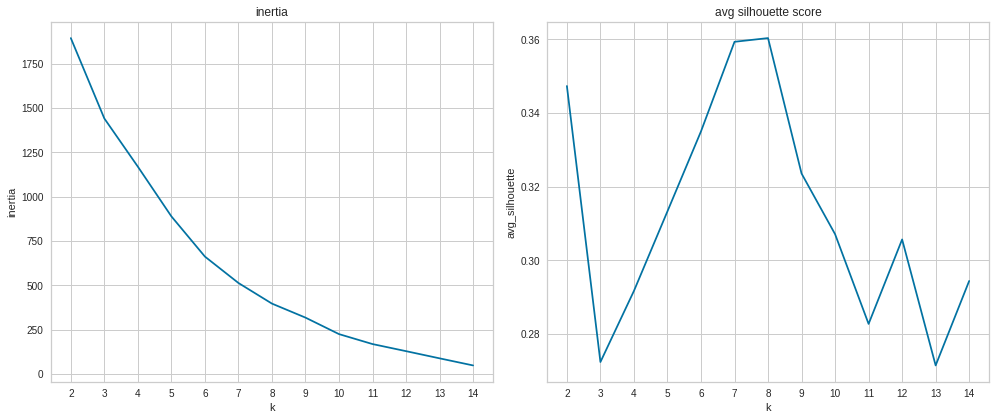

In [329]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title('inertia')
sns.lineplot(x=k_range, y=inertia_ls)
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(k_range)

plt.subplot(1, 2, 2)
plt.title('avg silhouette score')
sns.lineplot(x=k_range, y=score_ls)
plt.xlabel('k')
plt.ylabel('avg_silhouette')
plt.xticks(k_range)

plt.tight_layout()
plt.show()

In [272]:
# 편차 확인
for k in range(7, 9):
    X_copy = X.copy()
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(X)

    X_copy['cluster'] = kmeans.labels_
    X_copy['silhouette_coeff'] = silhouette_samples(X, X_copy['cluster'])

    score = silhouette_score(X, X_copy['cluster'])

    inertia_ls.append(kmeans.inertia_)
    score_ls.append(score)
    print(f'[k = {k}]')
    temp_df = X_copy[['cluster', 'silhouette_coeff']].groupby('cluster', as_index=False).mean()
    print('평균 편차 :', abs(temp_df['silhouette_coeff'] - score).mean())
    print('')

[k = 7]
평균 편차 : 0.25677072959717695

[k = 8]
평균 편차 : 0.26773595233742314



- elbow point로는 7, 8의 k가 적합한 것으로 보임
- 전체 군집 실루엣 스코어를 확인시에도 k=7, 8에서 최적의 k로 보임
- 7 or 8 중 선택을 위해 전체 군집의 실루엣 스코어와 개별 군집 실루엣 계수간 평균 편차를 구하고, 편차가 낮은 최적의 k를 구함
- k=7이 가장 최적화됬다고 판단됨

# 군집화 결과 시각화

In [291]:
X_tmp = df.drop(columns=['name', 'cluster'])
labels = df.cluster

In [293]:
from sklearn.decomposition import PCA

pca = PCA(2)
X_pca = pd.DataFrame(pca.fit_transform(X_tmp), columns=['pc1', 'pc2'])

In [295]:
X_pca['cluster'] = labels

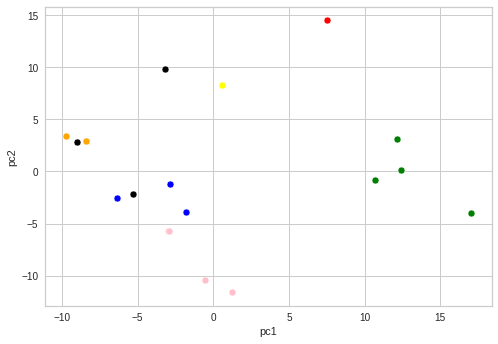

In [310]:
colors= ['red', 'blue', 'green', 'black', 'pink', 'yellow', 'orange']

for n_cluster in range(7):
    each_cluster_df = X_pca.loc[X_pca.cluster == n_cluster]
    sns.scatterplot(data=each_cluster_df, x='pc1', y='pc2', color=colors[n_cluster])

# 군집화된 경기 시퀀스 EDA

In [274]:
kmeans = KMeans(n_clusters=7, random_state=random_state)
kmeans.fit(X)

df['cluster'] = kmeans.labels_

In [311]:
df.sort_values(by='cluster')

,name,0,1,2,3,4,5,6,7,8,cluster
10,SV5_cPym_7o,6,7,5,4,3,2,18,8,9,0
9,jOUK8efu2EM,6,7,5,11,18,1,3,0,0,1
17,OZpVbV-CK2s,6,7,5,11,10,4,3,0,0,1
8,NPL3AENowDo,3,2,4,6,11,0,0,0,0,1
14,sNW-KwhVqZs,6,7,5,11,16,17,18,0,0,2
7,0I-1-U7bcgY,3,4,5,6,7,11,18,0,0,2
0,bidqBtK0Hd8,3,2,4,9,10,11,17,0,0,2
6,m_jhvqtmoE,3,2,4,9,10,11,15,0,0,2
11,Sodn83u_kFQ,11,6,7,18,1,3,0,0,0,3
12,uk4g0gt-NQE,13,12,14,9,2,3,8,0,0,3


In [322]:
readable_seq = []

for i in range(len(df)):
    seq = []
    for loc_idx in df.iloc[i, 1:10].values.tolist():
        if loc_idx == 0:
            break
        
        seq.append(idx2loc[loc_idx])
    readable_seq.append(seq)

['레드(상)', '돌골렘(상)', '칼날부리(상)', '바위게(상)', '미드', '바위게(하)', '돌골렘(하)']